In [30]:
# pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [31]:
IMG_SIZE = 128
# 64 of fast and 128 for better accuracy

In [32]:
head_images = []
tail_images = []
path="/content/drive/MyDrive/Colab Notebooks/heads-or-tails-image-classification/train/"
for i in range(1, 411):
    filename = f"{path}heads/heads_{i:03}.jpg"
    img = cv2.imread(filename)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        head_images.append(img)
    else:
        print(f"Image not found or cannot load: {filename}")
for i in range(1, 391):
    filename = f"{path}tails/tails_{i:03}.jpg"
    img = cv2.imread(filename)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        tail_images.append(img)
    else:
        print(f"Image not found or cannot load: {filename}")

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Combine images
X = np.array(head_images + tail_images)  # Shape: (num_samples, IMG_SIZE, IMG_SIZE, 3)
y = np.array([0]*len(head_images) + [1]*len(tail_images))  # 0 = head, 1 = tail

# Normalize pixel values to [0, 1]
X = X / 255.0  # Already float after cv2

print(f"Total samples: {X.shape[0]}")
print(f"Image shape: {X.shape[1:]}")
print(f"Labels: {np.unique(y, return_counts=True)}")

Total samples: 800
Image shape: (128, 128, 3)
Labels: (array([0, 1]), array([410, 390]))


In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 640
Validation samples: 160


In [35]:
model = Sequential()

# Layer 1 - Convolution + MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2 - Deeper convolution
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    X_train, y_train,
    epochs=10,                      # Start with 10; increase if needed
    batch_size=32,                  # Small batches help generalization
    validation_data=(X_val, y_val) # Monitor model performance
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 894ms/step - accuracy: 0.5027 - loss: 1.2795 - val_accuracy: 0.6562 - val_loss: 0.6481
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 884ms/step - accuracy: 0.6681 - loss: 0.6268 - val_accuracy: 0.6938 - val_loss: 0.5843
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 885ms/step - accuracy: 0.6987 - loss: 0.5789 - val_accuracy: 0.7063 - val_loss: 0.6278
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 964ms/step - accuracy: 0.7719 - loss: 0.4900 - val_accuracy: 0.6687 - val_loss: 0.5828
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 950ms/step - accuracy: 0.7622 - loss: 0.4797 - val_accuracy: 0.6750 - val_loss: 0.6204
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 877ms/step - accuracy: 0.8133 - loss: 0.4424 - val_accuracy: 0.6812 - val_loss: 0.6074
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 878ms/step - accuracy: 0.8229 - loss: 0.4043 - val_accuracy: 0.7000 - val_loss: 0.6164
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 864ms/step - accuracy: 0.8508 - loss: 0.3472 - val_accu

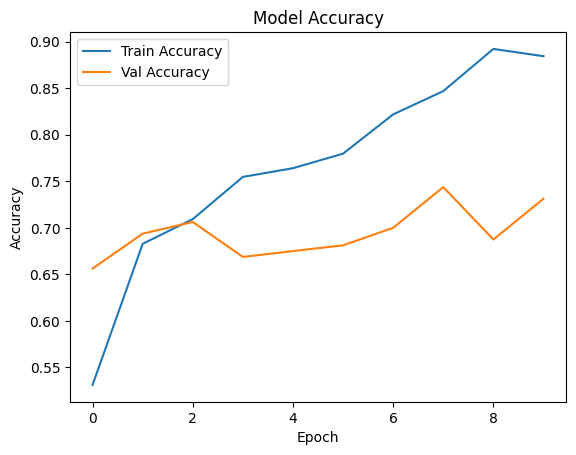

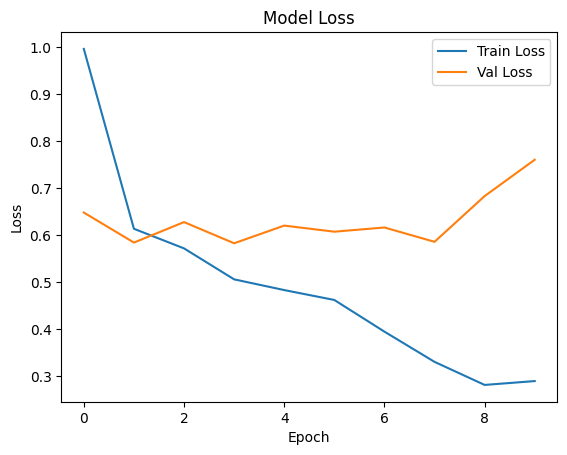

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
test_path = "/content/drive/MyDrive/Colab Notebooks/heads-or-tails-image-classification/test/"
test_images = []
test_filenames = []
for i in range(1, 201):
    filename = f"unknown_{i:03}.jpg"
    filepath = test_path + filename
    img = cv2.imread(filepath)
    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        test_images.append(img)
        test_filenames.append(filename)
    else:
        print(f"Image not found or couldn't load: {filename}")

X_test = np.array(test_images)
print(f"Loaded {len(X_test)} test images.")

Loaded 200 test images.


In [39]:
# Predict probabilities of class 1 (tail)
pred_probs = model.predict(X_test).reshape(-1)
# Probability of HEAD = 1 - probability of TAIL
prob_heads = 1 - pred_probs
submission = pd.DataFrame({
    "prediction_id": list(range(1, 201)),
    "probability_of_heads": prob_heads
})
submission.to_csv("submission.csv", index=False)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
